# Generating composite images <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one.

Some methods for generating composites include estimating the `median`, `mean`, `minimum`, or `maximum` pixel values in an image.
Care must be taken with these, as they do not necessarily preserve spectral relationships across bands. 
To learn how to generate a composite that does preserve these relationships, see the [Generating geomedian composites notebook](Generating_geomedian_composites.ipynb).

## Description
This notebook demonstrates how to generate a number of different composites from satellite images, and discusses the uses of each.
Specifically, this notebook demonstrates how to generate:

1. Median composites
2. Mean composites
3. Minimum and maximum composites

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
from xarray.core.duck_array_ops import first, last

sys.path.append('../Scripts')
from deafrica_plotting import rgb
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_bandindices import calculate_indices


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Generating_composites')

## Load Landsat 8 data

Here we load a timeseries of cloud-masked Landsat 8 satellite images through the datacube API using the [load_ard](Using_load_ard.ipynb) function.

In [3]:
# Set the area of interest
lat, lon = 13.94, -16.54
buffer = 0.25

# Create a reusable query
query = {
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'time': ('2017'),
    'measurements': ['green', 'red', 'blue', 'nir'],
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Load available data
ds = load_ard(dc=dc,
              products=['ls8_usgs_sr_scene'],
              output_crs=output_crs,
              align=(15, 15),
              **query)

# Print output data
print(ds)


Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 44 time steps
<xarray.Dataset>
Dimensions:      (time: 44, x: 1813, y: 1856)
Coordinates:
  * y            (y) float64 1.569e+06 1.569e+06 ... 1.514e+06 1.514e+06
  * time         (time) datetime64[ns] 2017-01-06T11:21:53.036448 ... 2017-12-31T11:27:37.598619
    spatial_ref  int32 0
  * x            (x) float64 3.064e+05 3.064e+05 ... 3.608e+05 3.608e+05
Data variables:
    green        (time, y, x) float32 nan nan nan nan ... 746.0 734.0 735.0
    red          (time, y, x) float32 nan nan nan nan ... 1030.0 1000.0 1019.0
    blue         (time, y, x) float32 nan nan nan nan ... 390.0 379.0 385.0
    nir          (time, y, x) float32 nan nan nan nan ... 2366.0 2351.0 2346.0
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


## Plot timesteps in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a series of timesteps. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

The code below will plot four timesteps of the time series we just loaded.

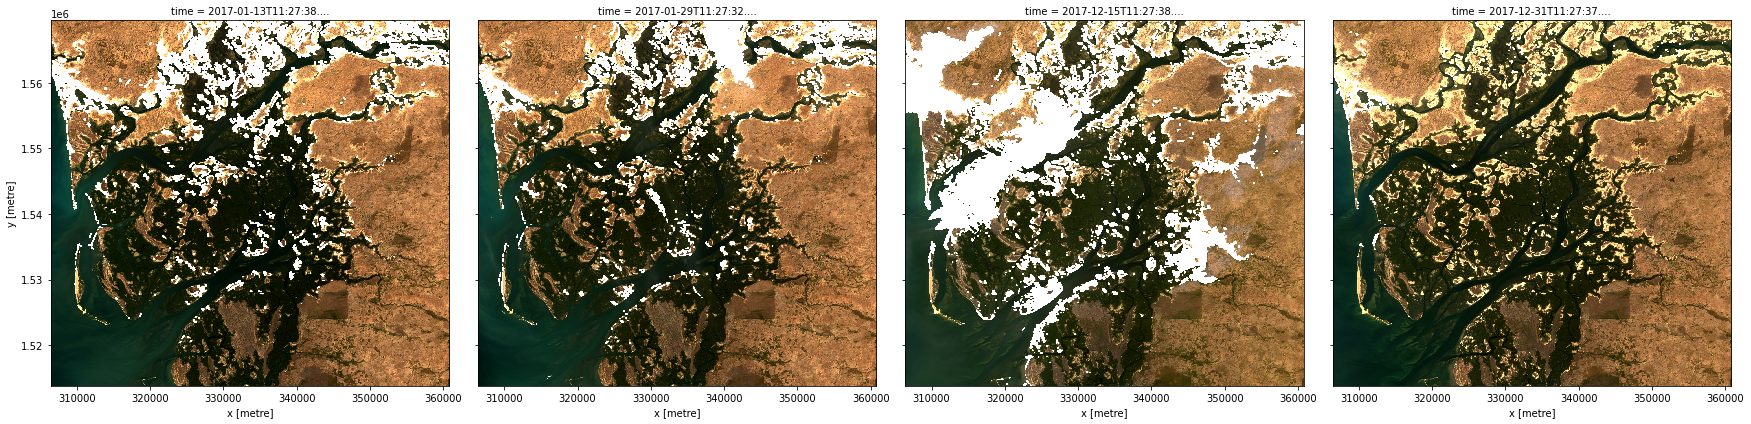

In [4]:
# Set the timesteps to visualise
timesteps = [1, 2, -3, -1]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)

## Median composites

One of the key reasons for generating a composite is to replace pixels classified as clouds with realistic values from the available data. 
This results in an image that doesn't contain any clouds.
In the case of a median composite, each pixel is selected to have the median (or middle) value out of all possible values.

Care should be taken when using these composites for analysis, since the relationships between spectral bands are not preserved.
These composites are also affected by the timespan they're generated over.
For example, the median pixel in a single season may be different to the median value for the whole year.

### Generating a single composite from all data

To generate a single median composite, we use the `xarray.median` method, specifying `'time'` as the dimension to compute the median over.

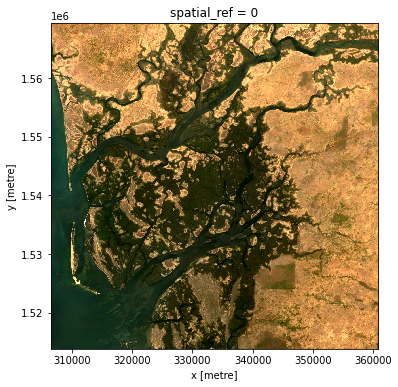

In [5]:
# Compute a single median from all data
ds_median = ds.median('time')

# View the resulting median
rgb(ds_median, bands=['red', 'green', 'blue'])

### Generating multiple composites based on length of time
Rather than using all the data to generate a single median composite, it's possible to use the `xarray.resample` method to group the data into smaller time-spans and generate medians for each of these.
Some resampling options are
* `'nD'` - number of days (e.g. `'7D'` for seven days)
* `'nM'` - number of months (e.g. `'6M'` for six months)
* `'nY'` - number of years (e.g. `'2Y'` for two years)

If the area is particularly cloudy during one of the time-spans, there may still be masked pixels that appear in the median.
This will be true if that pixel is always masked.

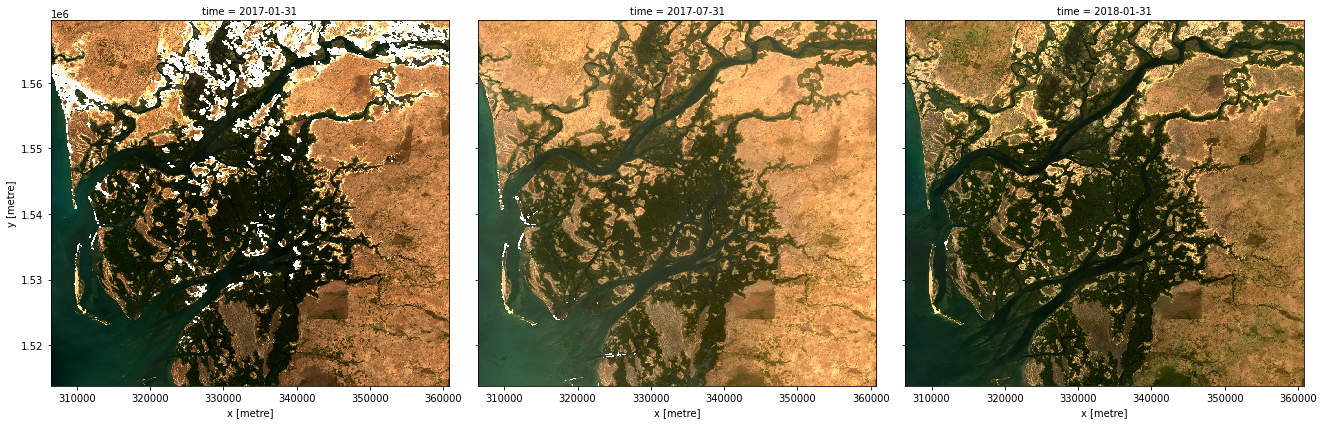

In [6]:
# Generate a median by binning data into six-monthly time-spans
ds_resampled_median = ds.resample(time='6M').median('time')

# View the resulting medians
rgb(ds_resampled_median, bands=['red', 'green', 'blue'], col='time')

## Mean composites

Mean composites involve taking the average value for each pixel, rather than the middle value as is done for a median composite.
Unlike the median, the mean composite can contain pixel values that were not part of the original dataset.
Care should be taken when interpreting these images, as extreme values (such as unmasked cloud) can strongly affect the mean.

### Generating a single composite from all data

To generate a single mean composite, we use the `xarray.mean` method, specifying `'time'` as the dimension to compute the mean over.

> **Note**: If there are no valid values for a given pixel, you may see the warning:
`RuntimeWarning: Mean of empty slice`. The composite will still be generated, but may have blank areas.

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


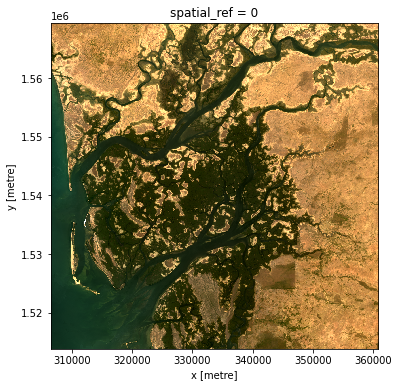

In [7]:
# Compute a single mean from all data
ds_mean = ds.mean('time')

# View the resulting mean
rgb(ds_mean, bands=['red', 'green', 'blue'])

### Generating multiple composites based on length of time
As with the median composite, it's possible to use the `xarray.resample` method to group the data into smaller time-spans and generate means for each of these.
See the previous section for some example resampling time-spans.

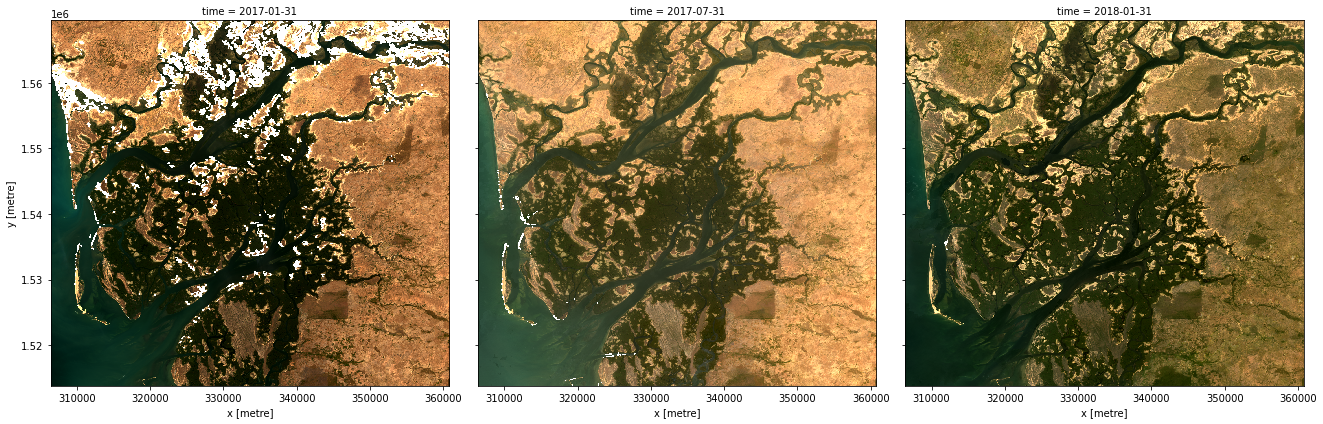

In [8]:
# Generate a mean by binning data into six-monthly time-spans
ds_resampled_mean = ds.resample(time='6M').mean('time')

# View the resulting medians
rgb(ds_resampled_mean, bands=['red', 'green', 'blue'], col='time')

## Minimum and maximum composites

These composites can be useful for identifying extreme behaviour in a collection of satellite images.

For example, comparing the maximum and minimum composites for a given band index could help identify areas that take on a wide range of values, which may indicate areas that have high variability over the time-line of the composite.

To demonstrate this, we start by calculating the normalised difference vegetation index (NDVI) for our data, which can then be used to generate the maximum and minimum composites.

In [9]:
# Start by calculating NDVI
ds = calculate_indices(ds, index='NDVI', collection='c1')

### Maximum composite

To generate a single maximum composite, we use the `xarray.max` method, specifying `'time'` as the dimension to compute the maximum over.

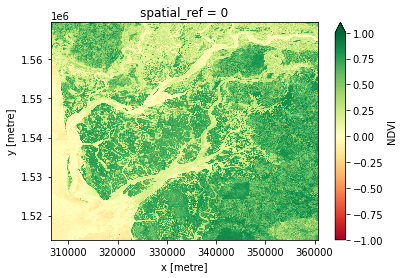

In [10]:
# Compute the maximum composite
ds_max = ds.NDVI.max('time')

# View the resulting composite
ds_max.plot(vmin=-1, vmax=1, cmap='RdYlGn')

### Minimum composite

To generate a single minimum composite, we use the `xarray.min` method, specifying `'time'` as the dimension to compute the minimum over.

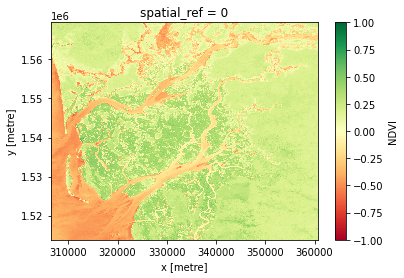

In [11]:
# Compute the minimum composite
ds_min = ds.NDVI.min('time')

# View the resulting composite
ds_min.plot(vmin=-1, vmax=1, cmap='RdYlGn')

## Time-based composites

### Most-recent composite

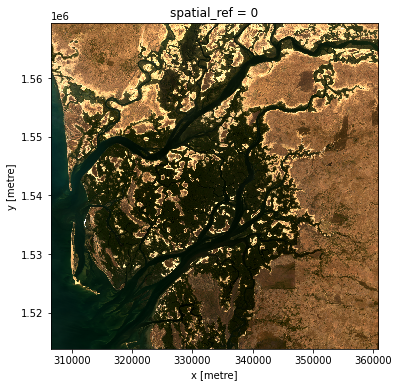

In [12]:
# Generate a composite with the latest value available for each pixel
ds_latest = ds.reduce(last, dim='time')

# View the resulting composite
rgb(ds_latest, bands=['red', 'green', 'blue'])

### Before and after composites

Often it is useful to view images before and after an event, to see the change that has occured.

To generate a composite on either side of an event, we can split the dataset along time.

We can then view the composite last image before the event, and the composite first image after the event.

In [13]:
# Dates here are inclusive. Use None to not set a start or end of the range.
before_event = slice(None, '2017-06-01')
after_event = slice('2017-06-03', None)

# Select the time period and group into a single image
ds_before = ds.sel(time=before_event).reduce(last, dim='time')
ds_after = ds.sel(time=after_event).reduce(first, dim='time')

Up to 2017-06-01


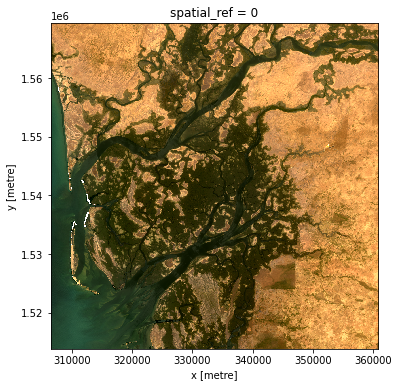

In [14]:
# View the resulting composites
print('Up to 2017-06-01')
rgb(ds_before, bands=['red', 'green', 'blue'])

From 2017-06-03


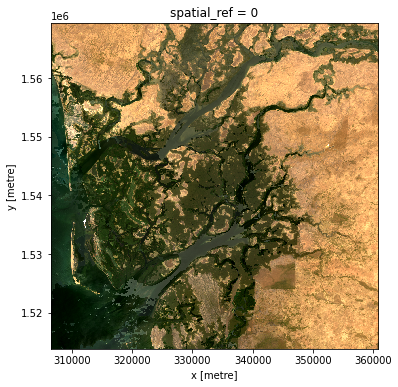

In [15]:
print('From 2017-06-03')
rgb(ds_after, bands=['red', 'green', 'blue'])

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.0b7.dev35+g5023dada


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)